In [4]:
%run preamble.py

In [5]:
# Set time range
end = dt.datetime.today()
start = dt.datetime.today() - dt.timedelta(days=60)

exp = pd.Timestamp('2023-09-15 00:00:00') # set option expiration date

# Define tickers
stocklist =['TSLA', 'AMD', 'AMZN', 'AAPL', 'NVDA', 'BAC', 'T', 
                  'INTC', 'GOOGL', 'MSFT', 'PFE', 'GOOG', 'META', 'VZ', 
                  'WFC', 'CSCO', 'CMCSA', 'PYPL', 'USB', 'XOM', 'DIS', 
                  'KO', 'SCHW', 'CSX', 'ORCL', 'JPM', 'CVS', 'QCOM', 'BMY', 
                  'NKE', 'CVX', 'JNJ', 'NEE', 'NFLX', 'MRK', 'MO', 'SBUX', 
                  'CRM', 'MDLZ', 'PG', 'V', 'AMAT', 'ABBV', 'TGT', 'GILD', 'WMT', 
                  'RTX', 'BA', 'CL', 'TXN', 'MDT', 'FIS', 'PEP', 'ABT', 'IBM', 
                  'PM', 'HD', 'SO', 'ADBE', 'MMM', 'D', 'UNH', 'UPS', 'DHR', 'PGR', 
                  'COF', 'AXP', 'CCI', 'CAT', 'MA', 'DUK', 'LOW', 'UNP', 
                  'AMGN', 'ACN', 'HON', 'SYY', 'MCD', 'GS', 'AMT', 'ICE', 'ZTS', 
                  'FDX', 'CB', 'INTU', 'COST', 'ADP', 'KMB', 'DE', 'TMO', 'ISRG', 
                  'CI', 'ILMN', 'ADSK', 'LIN', 'CME', 'NOW', 'WM', 'SYK', 'SPGI', 
                  'BDX', 'CHTR', 'STZ', 'LMT', 'APD', 'AON', 'REGN', 'BLK', 'EQIX', 'BKNG', 'CMG']

# Download stock data
stock_data = yf.download(stocklist, start, end)


# Initialize Yahoo Finance Ticker
t = Ticker(stocklist, asynchronous=True)
df = t.option_chain

# Filter and select columns from option chain DataFrame
option_df = df.loc[(slice(None)), :]
selected_columns = ['strike', 'bid', 'ask']
option_df = option_df[selected_columns]

# Calculate strike bounds based on stock price
S = stock_data['Close'].iloc[-1]
lower_strike = .90 * S
upper_strike = 1.1 * S

# Group option_df by ticker
grouped_by_ticker = option_df.groupby(level='symbol')
dataframes_by_ticker = {ticker: group for ticker, group in grouped_by_ticker}


# Filter options by strike and bid conditions for each ticker
option_dfs = [dataframes_by_ticker[ticker][(dataframes_by_ticker[ticker].strike <= upper_strike[ticker]) & 
                                            (dataframes_by_ticker[ticker].strike >= lower_strike[ticker]) & 
                                            (dataframes_by_ticker[ticker].bid != 0)] for ticker in stocklist]

# Find the DataFrame with the maximum number of rows (options)
m = max([len(X) for X in option_dfs])
max_option = [X for X in option_dfs if len(X) == m]
at_least10_options = [X for X in option_dfs if len(X) >= 10]


#Basic stock information
all_returns = stock_data['Close'].pct_change().dropna()
X = all_returns.rolling(window = 30).std().dropna()
sigma = np.mean(X)*np.sqrt(252)

options = [X.query('index.get_level_values("expiration") == @exp') for X in at_least10_options]

[*********************100%***********************]  111 of 111 completed


In [11]:
TSLA_options = options[0]
ticker = 'TSLA'


In [50]:
TSLA_options.head(),TSLA_options.tail()

(                              strike    bid    ask
 symbol expiration optionType                      
 TSLA   2023-09-15 calls       235.00  26.55  26.70
                   calls       237.50  24.45  24.55
                   calls       240.00  22.50  22.60
                   calls       241.67  21.15  21.25
                   calls       242.50  20.55  20.65,
                               strike    bid    ask
 symbol expiration optionType                      
 TSLA   2023-09-15 puts        273.33  18.15  18.25
                   puts        275.00  19.45  19.60
                   puts        280.00  23.45  23.55
                   puts        283.33  26.20  26.35
                   puts        285.00  27.60  27.70)

In [16]:
TSLA_stock = yf.download(ticker, start = dt.datetime.today()-dt.timedelta(days = 60), interval = '30m')

[*********************100%***********************]  1 of 1 completed


In [42]:
TSLA_returns = TSLA_stock.Close.pct_change().dropna()
TSLA_rolling_vol = TSLA_returns.rolling(window = 15).std().dropna()
sigma_rolling = TSLA_30_day_vol.values[-1]*np.sqrt(252)*np.sqrt(13)

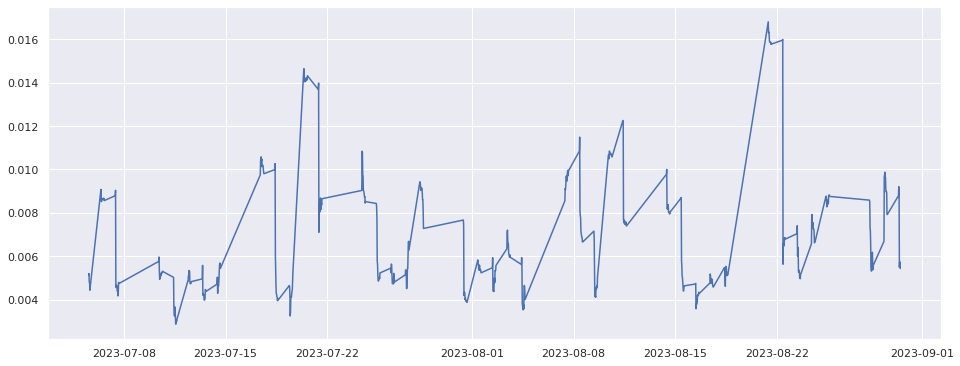

In [46]:
plt.plot(TSLA_rolling_vol)
plt.show()

In [43]:
sigma_rolling

0.4570794870729618

In [98]:
#GARCH volatility predictions accuracy vs 30-day rolling average

# Split Data into Training and Testing Sets
testing_set = TSLA_returns.iloc[-15:]
training_set = TSLA_returns.iloc[:-15]


training_set_scaled = training_set * 100

# Fit the GARCH(1,1) model to the rescaled training set
garch_model = arch_model(training_set_scaled, vol='Garch', p=5, q=1)
results = garch_model.fit(disp='off')

# Step 5: Calculate GARCH volatility for the testing set
garch_volatility_rescaled = results.conditional_volatility[-15:]/(100)

mse_GARCH = np.mean((np.array(garch_volatility_rescaled.values) - sigma_rolling)**2)
mse_rolling = np.mean((sigma_rolling - np.array(TSLA_rolling_vol.values[-15:]))**2)



print(f'The mse of rolling volatility predictions: {mse_rolling}')
print(f'The mse of GARCH volatility predicitions: {mse_GARCH}')


The mse of rolling volatility predictions: 0.2017599081842479
The mse of GARCH volatility predicitions: 0.20159984738047956


In [41]:
forecast = results.forecast(horizon = 12, reindex = True)
np.sqrt(forecast.variance.iloc[-1][-1])*np.sqrt(252)/100*np.sqrt(13)

0.44683031471665907

We estimate sigma as .45

In [47]:
sigma = .45

In [93]:
# Group option_df by expiration
grouped_by_expiration = TSLA_options.groupby('expiration')

#Only look at options expiring on 09/15/2023
TSLA_options_by_date = {expiration: group for expiration, group in grouped_by_expiration}
index = [key for key in TSLA_options_by_date.keys()][0]
TSLA_options = TSLA_options_by_date[index]


grouped_by_option_type = TSLA_options.groupby('optionType')
TSLA_calls_puts = {optionType: group for optionType, group in grouped_by_option_type}
TSLA_calls = TSLA_calls_puts['calls']
TSLA_puts = TSLA_calls_puts['puts']

In [91]:
S0 = TSLA_stock.Close.iloc[-1]
T = 12/252
TSLA_calls['bs_price'] = [bs('c', S0, TSLA_calls['strike'].iloc[i], T, 0, sigma) for i in range(len(TSLA_calls))]
TSLA_calls['market_price'] = (TSLA_calls['bid'] + TSLA_calls['ask'])/2
TSLA_calls['Price_difference'] = TSLA_calls['bs_price'] - TSLA_calls['market_price']
TSLA_calls['delta'] = [delta('c', S0, TSLA_calls['strike'].iloc[i], T, 0, sigma) for i in range(len(TSLA_calls))]
TSLA_calls

strike    bid    ask   bs_price  market_price  \
symbol expiration optionType                                                  
TSLA   2023-09-15 calls       235.00  26.55  26.70  26.866996        26.625   
                  calls       237.50  24.45  24.55  24.811326        24.500   
                  calls       240.00  22.50  22.60  22.828804        22.550   
                  calls       241.67  21.15  21.25  21.548136        21.200   
                  calls       242.50  20.55  20.65  20.925250        20.600   
                  calls       245.00  18.60  18.70  19.105934        18.650   
                  calls       246.67  17.45  17.55  17.939865        17.500   
                  calls       250.00  15.05  15.20  15.737558        15.125   
                  calls       253.33  13.05  13.15  13.704593        13.100   
                  calls       255.00  12.05  12.15  12.750261        12.100   
                  calls       258.33  10.25  10.35  10.978520        10.300   
                  calls       260.00   9.50   9.55  10.155691         9.525   
                  calls       265.00   7.20   7.30   7.950052         7.250   
                  calls       266.67   6.65   6.75   7.297264         6.700   
                  calls       270.00   5.55   5.60   6.115378         5.575   
                  calls       273.33   4.60   4.65   5.085126         4.625   
                  calls       275.00   4.15   4.25   4.622188         4.200   
                  calls       280.00   3.10   3.20   3.432967         3.150   
                  calls       283.33   2.57   2.59   2.789021         2.580   
                  calls       285.00   2.33   2.36   2.505867         2.345   

                              Price_difference     delta  
symbol expiration optionType                              
TSLA   2023-09-15 calls               0.241996  0.859185  
                  calls               0.311326  0.833703  
                  calls               0.278804  0.805730  
                  calls               0.348136  0.785718  
                  calls               0.325250  0.775396  
                  calls               0.455934  0.742893  
                  calls               0.439865  0.720091  
                  calls               0.612558  0.672402  
                  calls               0.604593  0.622406  
                  calls               0.650261  0.596731  
                  calls               0.678520  0.544894  
                  calls               0.630691  0.518804  
                  calls               0.700052  0.441635  
                  calls               0.597264  0.416522  
                  calls               0.540378  0.367992  
                  calls               0.460126  0.322039  
                  calls               0.422188  0.300127  
                  calls               0.282967  0.239620  
                  calls               0.209021  0.203857  
                  calls               0.160867  0.187332

In [92]:
S0 = TSLA_stock.Close.iloc[-1]
T = 12/252
TSLA_puts['bs_price'] = [bs('p', S0, TSLA_puts['strike'].iloc[i], T, 0, sigma) for i in range(len(TSLA_puts))]
TSLA_puts['market_price'] = (TSLA_puts['bid'] + TSLA_puts['ask'])/2
TSLA_puts['Price_difference'] = TSLA_puts['bs_price'] - TSLA_puts['market_price']
TSLA_puts['delta'] = [delta('p', S0, TSLA_puts['strike'].iloc[i], T, 0, sigma) for i in range(len(TSLA_puts))]
TSLA_puts

strike    bid    ask   bs_price  market_price  \
symbol expiration optionType                                                  
TSLA   2023-09-15 puts        235.00   1.96   1.98   1.916709         1.970   
                  puts        237.50   2.34   2.36   2.361040         2.350   
                  puts        240.00   2.80   2.81   2.878517         2.805   
                  puts        241.67   3.10   3.20   3.267849         3.150   
                  puts        242.50   3.30   3.35   3.474963         3.325   
                  puts        245.00   3.90   4.00   4.155647         3.950   
                  puts        246.67   4.40   4.50   4.659578         4.450   
                  puts        250.00   5.45   5.55   5.787271         5.500   
                  puts        253.33   6.70   6.75   7.084306         6.725   
                  puts        255.00   7.35   7.40   7.799974         7.375   
                  puts        258.33   8.90   8.95   9.358233         8.925   
                  puts        260.00   9.70   9.80  10.205404         9.750   
                  puts        265.00  12.55  12.65  12.999765        12.600   
                  puts        266.67  13.60  13.65  14.016977        13.625   
                  puts        270.00  15.85  15.95  16.165092        15.900   
                  puts        273.33  18.15  18.25  18.464839        18.200   
                  puts        275.00  19.45  19.60  19.671901        19.525   
                  puts        280.00  23.45  23.55  23.482680        23.500   
                  puts        283.33  26.20  26.35  26.168734        26.275   
                  puts        285.00  27.60  27.70  27.555580        27.650   

                              Price_difference     delta  
symbol expiration optionType                              
TSLA   2023-09-15 puts               -0.053291 -0.140815  
                  puts                0.011040 -0.166297  
                  puts                0.073517 -0.194270  
                  puts                0.117849 -0.214282  
                  puts                0.149963 -0.224604  
                  puts                0.205647 -0.257107  
                  puts                0.209578 -0.279909  
                  puts                0.287271 -0.327598  
                  puts                0.359306 -0.377594  
                  puts                0.424974 -0.403269  
                  puts                0.433233 -0.455106  
                  puts                0.455404 -0.481196  
                  puts                0.399765 -0.558365  
                  puts                0.391977 -0.583478  
                  puts                0.265092 -0.632008  
                  puts                0.264839 -0.677961  
                  puts                0.146901 -0.699873  
                  puts               -0.017320 -0.760380  
                  puts               -0.106266 -0.796143  
                  puts               -0.094420 -0.812668

We explore the following option position and the expectation of dynamically hedging.

0) sell 200 calls at strike price 242.50
1) buy 100 calls at strike price 258.33
2) buy 100 calls at strike price 265
3) buy 200 puts at strike price 260
4) sell 200 puts at strike price 273.33

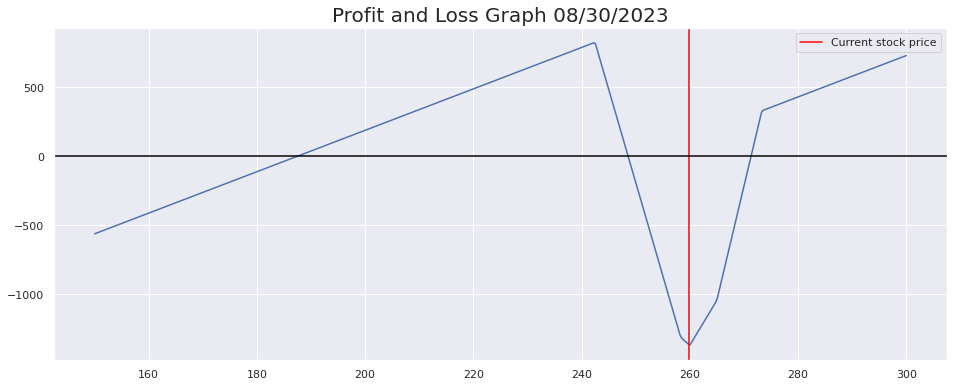

In [124]:
K0 = 242.50
K1 = 258.33
K2 = 265
K3 = 260
K4 = 273.33
p0 = 20.60
p1 = 10.30
p2 = 7.25
p3 = 9.75
p4 = 18.20

stock_prices = np.linspace(150,300, 500)
call0 = np.maximum(stock_prices - K0, 0)
call1 = np.maximum(stock_prices - K1, 0)
call2 = np.maximum(stock_prices - K2, 0)
put3 = np.maximum(-stock_prices + K3, 0)
put4 = np.maximum(-stock_prices + K4, 0)

n0 = -150
n1 = 100
n2 = 100
n3 = 100
n4 = -150

delta0 = delta('c', S0, K0, T, 0, sigma)
delta1 = delta('c', S0, K1, T, 0, sigma)
delta2 = delta('c', S0, K2, T, 0, sigma)
delta3 = delta('p', S0, K3, T, 0, sigma)
delta4 = delta('p', S0, K4, T, 0, sigma)

position_delta = n0*delta0 + n1*delta1 + n2*delta2 + n3*delta3 + n4*delta4

position = n0*(call0-p0) + n1*(call1-p1) + n2*(call2-p2) + n3*(put3-p3) + n4*(put4-p4) - int(position_delta)*(stock_prices - S0)


plt.plot(stock_prices,position)
plt.axvline(x = S0, color = 'red', label = 'Current stock price')
plt.axhline(y=0, color = 'black')
plt.title('Profit and Loss Graph 08/30/2023', size = 20)
plt.legend()
plt.show()

In [147]:
#Monte Carlo simulation of expected profit
steps = 12
DT = T / steps
TTE = [T - DT * i for i in range(0, steps + 1)]
r = 0
N = 1000000


stock_path = geo_paths(S0, T, sigma, steps, N)
avg_stock_values = [np.mean(stock_path[i]) for i in range(len(stock_path))]


option_value0 = np.maximum(stock_path[-1] - K0, 0)
option_value1 = np.maximum(stock_path[-1] - K1, 0)
option_value2 = np.maximum(stock_path[-1] - K2, 0)
option_value3 = np.maximum(-stock_path[-1] + K3, 0)
option_value4 = np.maximum(-stock_path[-1] + K4, 0)


delta0 = [delta('c', avg_stock_values[i], K0, TTE[i], 0 , sigma) for i in range(len(avg_stock_values))]
delta1 = [delta('c', avg_stock_values[i], K1, TTE[i], 0 , sigma) for i in range(len(avg_stock_values))]
delta2 = [delta('c', avg_stock_values[i], K2, TTE[i], 0 , sigma) for i in range(len(avg_stock_values))]
delta3 = [delta('p', avg_stock_values[i], K3, TTE[i], 0 , sigma) for i in range(len(avg_stock_values))]
delta4 = [delta('p', avg_stock_values[i], K4, TTE[i], 0 , sigma) for i in range(len(avg_stock_values))]

X0 = [-delta0[i] * ((stock_path[i + 1] - stock_path[i])) for i in range(steps)]
X1 = [-delta1[i] * ((stock_path[i + 1] - stock_path[i])) for i in range(steps)]
X2 = [-delta2[i] * ((stock_path[i + 1] - stock_path[i])) for i in range(steps)]
X3 = [-delta3[i] * ((stock_path[i + 1] - stock_path[i])) for i in range(steps)]
X4 = [-delta4[i] * ((stock_path[i + 1] - stock_path[i])) for i in range(steps)]


total_hedge0 = np.sum(X0, axis=0)
total_hedge1 = np.sum(X1, axis=0)
total_hedge2 = np.sum(X2, axis=0)
total_hedge3 = np.sum(X3, axis=0)
total_hedge4 = np.sum(X4, axis=0)

position_with_hedge0 = option_value0 + total_hedge0
position_with_hedge1 = option_value1 + total_hedge1
position_with_hedge2 = option_value2 + total_hedge2
position_with_hedge3 = option_value3 + total_hedge3
position_with_hedge4 = option_value4 + total_hedge4

total_position_profit = n0*(position_with_hedge0 - p0) + n1*(position_with_hedge1 - p1) + n2*(position_with_hedge2 - p2) + \
n3*(position_with_hedge3 - p3) + n4*(position_with_hedge4 - p4)

amount_invested = -np.min(position)
stand_err = standard_error(total_position_profit, T)
profit_chance = per_in_money_paths(total_position_profit)
expected_profit = np.mean(total_position_profit)
roi = expected_profit/amount_invested


print(f"Amount Invested: {amount_invested}")
print(f'Expected profit: {expected_profit}')
print(f'Standard Error: {stand_err}')
print(f'Chance of profit: {profit_chance*100}%')
print(f'Expected return on investment: {round(roi*100,2)}%')







Amount Invested: 1367.93735450637
Expected profit: 95.43343144809626
Standard Error: 0.726332709248837
Chance of profit: 65.2744%
Expected return on investment: 6.98%


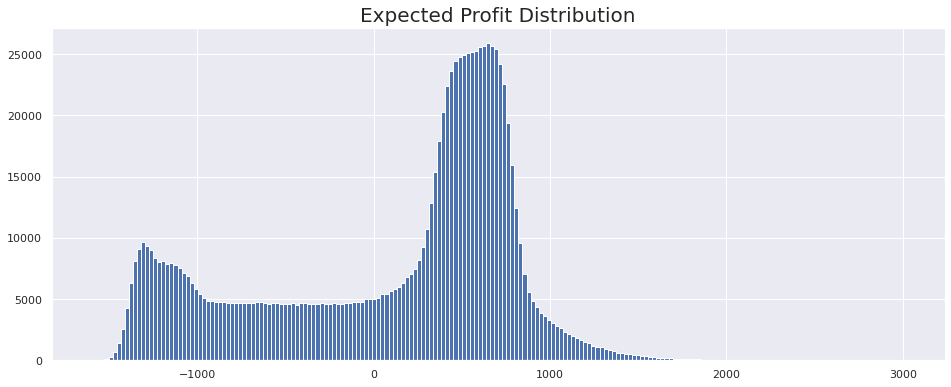

In [148]:
plt.hist(total_position_profit, bins = 200)
plt.title('Expected Profit Distribution', size = 20)
plt.show()